In [42]:
from IPython.display import Image
from lib.utils import *

# Generative Adversarial Networks - 50 points

Please review Lectures 10-11 for the notation and the setup in this exercise.

As a basic example for the implementation of GANs, we will try to learn the density of a 2D mixture of Gaussian (MoG) distribution from empirical samples using the Wasserstein GAN (WGAN) framework. MoG distributions are multi-modal, and allow to us visualize multiple "modes" of the distribution. 

Both your generator neural network $h_\mathbf{x}$ and dual variable neural network $\mathtt{d}_\mathbf{y}$ are defined as two hidden layer networks:

\begin{equation}
    \mathcal{H}:=\{h: h_{\mathbf{x}}(\omega)=X_3\texttt{relu}(X_2\texttt{relu}(X_1 \omega + x_1)+ x_2) + x_3\},
    \qquad \mathcal{D}:= \{\mathtt{d}: \mathtt{d}_{\mathbf{x}}({\bf a})=
    Y_3\texttt{relu}(Y_2\texttt{relu}(Y_1 {\bf a} + y_1)+ y_2)+y_3\},
\end{equation}

where $\mathbf{x} =[x_1;x_2;{X_1};{X_2}; X_3]$ are the "generator" parameters, and $\mathbf{y} =[y_1;y_2;{Y_1};{Y_2}; Y_3] $ are the
"dual" or the "discriminator" parameters. The dimensions of these parameters will be apparent from the context as well as the base code provided along with the homework. 

In the following cells, you will implement the two neural networks as well as the spectral normalization ([Myato 2018](https://arxiv.org/abs/1802.05957)) method that enforces a Lipschitz constraint.

**(1)** (3 points) Implement a two hidden layer MLP with ReLU below for the generator. See `torch.nn.Sequential` docs for a start.

In [43]:
class Generator(nn.Module):

    def __init__(self, noise_dim=2, output_dim=2, hidden_dim=100):
        super().__init__()
        
        self.inner = torch.nn.Sequential(nn.Linear(noise_dim,hidden_dim), nn.ReLU(), nn.Linear(hidden_dim,hidden_dim), nn.ReLU(), nn.Linear(hidden_dim,output_dim))

    def forward(self, z):
        return self.inner(z)

**(2)** (20 points) Implement a two hidden layer MLP with ReLU below for the Discriminator and implement the spectral normalization method.

**Remark:** The `spectral_normalization` does not need to return a value. It should modify the parameters $\mathbf{y}$ of the dual network $\mathtt{d}_{\mathbf{y}}$ in place. Remember not to track gradients in those operations.

In [44]:
class DualVariable(nn.Module):

    def __init__(self, input_dim=2, hidden_dim=100, c=1e-5):
        super().__init__()
        self.c = c
        
        self.inner = torch.nn.Sequential(nn.Linear(input_dim,hidden_dim), nn.ReLU(), nn.Linear(hidden_dim,hidden_dim), nn.ReLU(), nn.Linear(hidden_dim,1))

    def forward(self, x):
        return self.inner(x)

    def enforce_lipschitz(self):
        self.spectral_normalisation()

    def spectral_normalisation(self):
        """
        Perform spectral normalisation, forcing the singular value of the weights to be upper bounded by 1.
        """
        with torch.no_grad():
           for name, param in self.named_parameters():
                if 'weight' in name:
                    # spectal normalization reduces to division by l-2 norm for a weight vector
                    norm_weights = param/(torch.linalg.norm(param, ord = 2))

                    param.copy_(norm_weights)

**(3)** (2 points) Spectral Normalization applied to a matrix outputs a matrix whose largest singular value is upper bounded by one. Is Spectral Normalization a projection (in the $\ell_2$ sense) ? Think of a diagonal square matrix and try figure out what spectral normalization does and compare that to what a projection onto the set of matrices with largest singular value less than 1 would do.

$\textbf{Ans.}$ The output of Spectral Normalization on Matrix M is given by $X_1 = M/\sigma(M)$ where $\sigma(M)$ represents the largest singular value of the Matrix M. $\newline$ For a set $A \coloneqq \{X\in A: \sigma(X)\leq 1\}$ represents the set of matrices with the largest singular value less than or equal to 1. $\newline$ Then we can pose the problem of projection to A (in the $\ell$-2 sense) as $X_2(M) = \argmin_{X \in A} \|X - M\|_F$. 

As suggested in the Hint, lets take $ M = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}$ then we have, $\newline$
$$
    X_1(M) = \frac{M}{2} = \begin{bmatrix} 1 & 0 \\ 0 & 1/2 \end{bmatrix} \newline
    X_2(M) =  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \newline
$$
Since $X_1 \ne X_2$ for the chosen M, we can conclude that Spectral Normalization is not a projection (in the $\ell_2$ sense).

**(3)** (1 point) Implement a stochastic estimate of the objective function of the minimax game (in the cell below):

$$
\min_{\mathbf{x} \in \mathcal{X}} \max_{\mathbf{y} \in \mathcal{Y}} 
\mathbb{E}[\mathtt{d}_{\mathbf{y}}({\bf a})] - \mathbb{E}[\mathtt{d}_{\mathbf{y}}(h_{\mathbf{x}}(\omega))] = 
\min_{h \in \mathcal{H}} \max_{\mathtt{d} \in \mathcal{F}}
\mathbb{E}[\mathtt{d}({\bf a})] - \mathbb{E}[\mathtt{d}(h(\omega))],
$$

In [45]:
def objective(d, g, data_sample, noise_sample):
    # calculating stochastic estimate using the empirical mean
    W1 = d(data_sample).mean() - d(g(noise_sample)).mean()
    return W1

**(4)** (20 points) Implement an alternating gradient ascent/descent update, training the generator 1 time for every 5 dual updates. More specifically, you will implement the conceptual algorithm below using the parameters of the neural networks

$$
\begin{aligned}
\mathtt{d}^{k+1} &= \text{EnforceLipschitz} (\mathtt{d}^k + \gamma \text{SG}_\mathtt{d}(\mathtt{d}^k, h^kk)), && \text{(if $k$ mod $5 \neq 0$) }\\
h^{k+1} &= h^{k} - \gamma \text{SG}_h(\mathtt{d}^{k+1}, h^k) && \text{(if $k$ mod $5 =0$)},
\end{aligned}
$$

where $\text{SG}$ is the stochastic gradient oracle. To perform the optimization, you have two `Pytorch` optimizers `d_optim` and `g_optim`, which have a `.step()` method that updates the discriminator and generator parameters respectively.

Use the objective function you have just written. The iteration count is held by the `step_k` argument. The agument `d_ratio` defines how many more times we train the discriminator that train the generator. 

For later, to display the progress, write the function so that it returns the value of the objective function.

**Hints**: Don't forget that the generator seeks to minimize and the discriminator seeks to maximize. Pytorch optimizers step in the _negative_ gradient direction, keep that in mind.

In [46]:
def alternating_update(step_k, d, g, d_optim, g_optim, noise_samples, real_samples, d_ratio=5):
    
    l = objective(d, g, real_samples, noise_samples)

    if step_k % d_ratio==0:
        d.eval()
        g.train()

        l.backward()

        g_optim.step()

    else:
        d.train()
        g.eval()

        loss = -l
        loss.backward()

        d_optim.step()
        
        #Enforce 1-lipschitz contraint on the discriminator weights after the updates
        d.enforce_lipschitz()
    
    g_optim.zero_grad()
    d_optim.zero_grad()

    return l

With all the ingredients in hand, we can train our GAN.

The following cell defines the two networks.

In [59]:
hidden_dim = 20
d = DualVariable(input_dim=2, hidden_dim=hidden_dim, c=1.0)
g = Generator(noise_dim=2, output_dim=2, hidden_dim=hidden_dim)

**(5)** (2 points) Define an optimizer for each of the networks. We recommend choosing `Adam` with betas $(0.0, 0.9)$.

In [60]:
d_optim = torch.optim.Adam(d.parameters(), betas=(0, 0.9), lr = 0.03)
g_optim = torch.optim.Adam(g.parameters(), betas=(0, 0.9), lr = 0.03)

The following cell runs the training loop for 2000 iterations, this might take a few minutes.

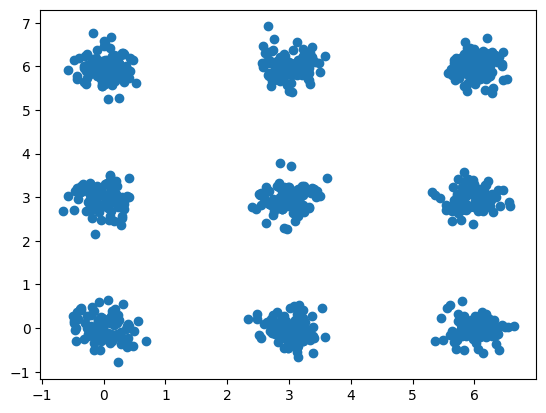

W1:0.12 GTrue: 100%|██████████| 2000/2000 [09:53<00:00,  3.37it/s]     


<Figure size 640x480 with 0 Axes>

In [61]:
train(d, g, d_optim, g_optim, alternating_update, n_iter=2000)

Once the training is complete, you can visualize the training process in the following gif. (If you encounter problems seeing the gif, open it in a separate tab, it can be found in the same directory as this notebook).

In [ ]:
Image("movie.gif")

**(6)** (2 points) Briefly comment on what you observe. Play with the network sizes, the step sizes, the number of iterations, all while keeping in mind the difficulties of min-max optimization you've analyzed in the previous notebook.

After playing with the different parameters I observed the following on variation of the different parameters :
1. Step size : Larger step sizes like 0.5 or 0.1 lead to large fluctuations in objective value, suggesting that the step sizes must be much smaller. I observed the best reults around step size = 0.03, where the movie.gif was visibly learning the underlying distribution over the iterations.
2. Number of iterations : The model displays good convergence around 1000 iterations and then keeps trying to figure out better fits for the data samples.
3. Network size: The network size should be big enough to account for the varibles in the data sample distribution. I observed poor performance for larger network sizes e.g. 100 hidden dimensions. 20 hidden dimensions seemed to give good performance and reliable convergence behaviour for the given problem.